In [4]:
from io import StringIO
import pandas as pd
import requests
from wmfdata import charting, hive
from wmfdata.utils import pct_str, sig_figs, pd_display_all

In [5]:
%matplotlib inline
charting.set_mpl_style()

# Replica-based ("official") metrics

Up until February, active editors were calculated using the following procedure. For the initial run (probably some time in 2018), the procedure was run for all previous time. Then, each month, it was re-run to add data for the previous month.

First, we built an [editor month dataset](https://meta.wikimedia.org/wiki/Research:Editor_month_dataset) by running [the update_editor_month query](https://github.com/wikimedia-research/Editing-movement-metrics/blob/3f5322cc1302419114ea7f647fdf4592063c6a35/queries/update_editor_month.sql) (or [a rewritten version](https://github.com/wikimedia-research/Editing-movement-metrics/blob/f6db91f3c64ffc05ae6eeda599755af744928803/queries/update_editor_month.sql) in January 2018) on [a specific selection of wikis](https://github.com/neilpquinn/wmfdata/blob/b0548529c4d39fc37f40fb637025e8a9b428a33f/wmfdata/mariadb.py#L94) sequentially.


Then, the active editor numbers were calculated using [an SQL query](https://github.com/wikimedia-research/Editing-movement-metrics/blob/f6db91f3c64ffc05ae6eeda599755af744928803/queries/active_editors.sql) on that editor-month table.

This gave the following, which is our currently accepted version of reality:

In [33]:
metrics_url = "https://raw.githubusercontent.com/wikimedia-research/Editing-movement-metrics/75b3251727f8c766e4872f775f57a09632df6500/metrics/metrics.tsv"
metrics_stream = StringIO(requests.get(metrics_url).text)

official_ae = pd.read_csv(
    metrics_stream,
    sep="\t",
    parse_dates=["month"]  
).set_index("month")["active_editors"].to_frame()

official_ae.tail()

,active_editors
month,
2018-09-01,82084.0
2018-10-01,82567.0
2018-11-01,82584.0
2018-12-01,81075.0
2019-01-01,86776.0


# Data Lake-based ("new") metrics

For February's metrics, we switched to calculating these based on the `mediawiki_history` dataset in the Data Lake. 

First, we built an editor-month table using the following SQL: 
```sql
insert into neilpquinn.editor_month
select
    trunc(event_timestamp, "MONTH") as month,
    wiki_db,
    event_user_id as local_user_id,
    max(event_user_text) as user_name, -- Some rows incorrectly have a null `event_user_text`
    count(*) as edits,
    coalesce(
        sum(cast(page_namespace_is_content_historical as int)),
        0
    ) as content_edits,
    NULL as mobile_web_edits,
    NULL as mobile_app_edits,
    NULL as visual_edits,
    NULL as ve_source_edits,
    (
        max(event_user_is_bot_by_name) or 
        max(array_contains(event_user_groups, "bot")) or
        max(array_contains(event_user_groups_historical, "bot"))
    ) as bot,
    min(event_user_creation_timestamp) as user_registration
from wmf.mediawiki_history
where
    event_timestamp between "{start}" and "{end}" and
    event_entity = "revision" and
    event_type = "create" and
    snapshot = "{mwh_snapshot}"
group by
    trunc(event_timestamp, "MONTH"),
    wiki_db,
    event_user_id
```

In [27]:
new_ae = (
    hive.run("""
    select
        month,
        count(*) as active_editors
    from (
        select
            cast(month as date) as month,
            user_name,
            sum(content_edits) as content_edits,
            max(bot) as bot
        from neilpquinn.editor_month
        where
            month < "2019-02-01" and
            local_user_id != 0
        group by month, user_name
    ) global_edits
    where
        content_edits >= 5 and
        (not bot or user_name in ("Paucabot", "Niabot", "Marbot"))
    group by month
    """)
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

These differ a LOT from the replica-based metrics.

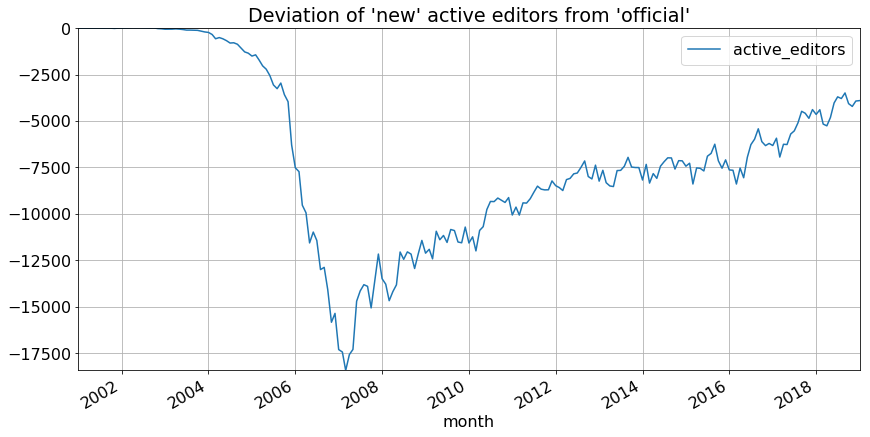

In [34]:
(new_ae - official_ae).plot(title="Deviation of 'new' active editors from 'official'");

# Load editor month datasets for comparisons

Let's directly compare the official version of the dataset with the new one (tweaked to eliminate a few obvious differences). 

In [ ]:
staging_host = !analytics-mysql -d staging --print-target
staging_host = staging_host[0]
jdbc_uri = "jdbc:mysql://" + staging_host + "/staging"
cnf_path = "/etc/mysql/conf.d/research-client.cnf"
sqoop_query = """
select
    convert(wiki using utf8) as wiki,
    cast(month as datetime) as month,
    local_user_id,
    convert(user_name using utf8) as user_name,
    edits,
    content_edits,
    bot_flag,
    user_registration
from editor_month
where $CONDITIONS
"""

!sqoop import --connect {jdbc_uri} --connection-param-file {cnf_path} --query '{sqoop_query}' \
--split-by local_user_id --target-dir /user/neilpquinn-wmf/editor_month_official_raw \
--hive-import --hive-table neilpquinn.editor_month_official \
--map-column-hive month=timestamp,user_registration=timestamp

In [407]:
hive.run(["""
CREATE TABLE IF NOT EXISTS neilpquinn.editor_month_new (
  `wiki` STRING,
  `month` TIMESTAMP, -- Hive 1.1 does not support the DATE type
  `local_user_id` BIGINT,
  `user_name` STRING,
  `edits` BIGINT,
  `content_edits` BIGINT,
  `bot_flag` BOOLEAN,
  `user_registration` TIMESTAMP
) 
STORED AS PARQUET
""", """
insert into neilpquinn.editor_month_new
select
    wiki_db as wiki,
    trunc(event_timestamp, "MONTH") as month,
    event_user_id as local_user_id,
    max(event_user_text) as user_name, -- Some rows incorrectly have a null `event_user_text`
    count(*) as edits,
    coalesce(
        sum(cast(page_namespace_is_content_historical as int)),
        0
    ) as content_edits,
    (
        max(array_contains(event_user_groups, "bot")) or 
        max(array_contains(event_user_groups_historical, "bot"))
    ) as bot,
    min(event_user_creation_timestamp) as user_registration
from wmf.mediawiki_history
where
    event_timestamp < "2019-02-01" and
    event_entity = "revision" and
    event_type = "create" and
    snapshot = "2019-03"
group by
    trunc(event_timestamp, "MONTH"),
    wiki_db,
    event_user_id
"""])

Let's make sure these datasets have the same active editors discrepancy.

In [408]:
ae_query = """
select
    month,
    count(*) as active_editors
from (
    select
        cast(month as date) as month,
        user_name,
        sum(content_edits) as content_edits,
        max(bot_flag) as bot_flag
    from neilpquinn.{table}
    where 
        local_user_id != 0
    group by month, user_name
) global_edits
where
    content_edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_query = ae_query.format(table="editor_month_official")
emn_ae_query = ae_query.format(table="editor_month_new")

emo_ae = hive.run(emo_ae_query).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")
emn_ae = hive.run(emn_ae_query).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")

Yup, it's the same. So we can proceed to compare just these two datasets.

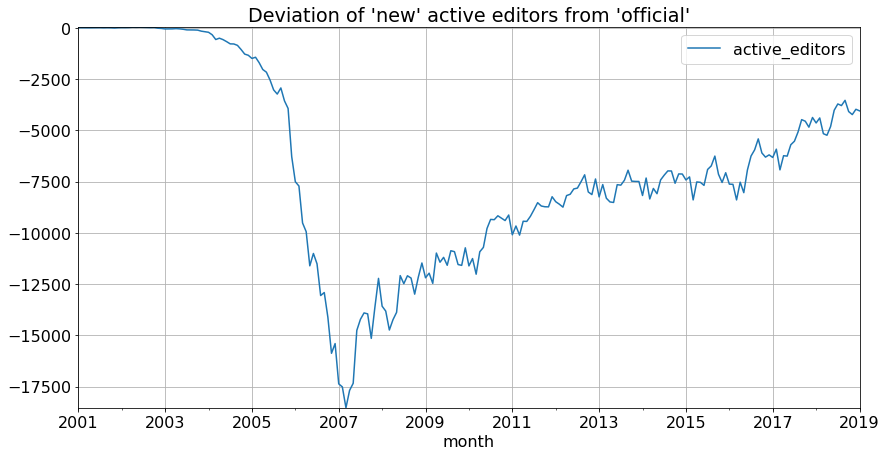

In [410]:
(emn_ae - emo_ae)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

# Wiki inclusion

It looks there are discrepancies in which wikis are included.

In [412]:
emo_wikis = hive.run("""
select distinct wiki
from neilpquinn.editor_month_official
""")
emo_wikis = set(emo_wikis["wiki"].unique())


emn_wikis = hive.run("""
select distinct wiki
from neilpquinn.editor_month_new
""")
emn_wikis = set(emn_wikis["wiki"].unique())

The extra wikis included in `editor_month_official` seem to be a miscellaneous collection that are [mistakenly not included](https://phabricator.wikimedia.org/T220456) in `mediawiki_history`.

In [414]:
extra_emo_wikis = emo_wikis - emn_wikis
len(extra_emo_wikis)

119

The extra wikis included in `editor_month_new` are a mixture of test wikis, infrastructure wikis (`donatewiki`, `loginwiki`), and affiliate wikis that are only there because I forgot to port the logic excluding them from the replicas-based pipeline to the Data Lake-based one.

In [415]:
extra_emn_wikis = emn_wikis - emo_wikis
len(extra_emn_wikis)

34

Let's see what the discrepancy looks like when we exclude these extra wikis.

In [421]:
ae_same_wikis_sql = """
select
    month,
    count(*) as active_editors
from (
    select
        cast(month as date) as month,
        user_name,
        sum(content_edits) as content_edits,
        max(bot_flag) as bot_flag
    from neilpquinn.{table}
    where 
        local_user_id != 0 and
        wiki not in {excluded_wikis!r}
    group by month, user_name
) global_edits
where
    content_edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_same_wikis_sql = ae_same_wikis_sql.format(
    table="editor_month_official",
    excluded_wikis=tuple(extra_emo_wikis)
)

emn_ae_same_wikis_sql = ae_same_wikis_sql.format(
    table="editor_month_new",
    excluded_wikis=tuple(extra_emn_wikis)
)

emo_ae_same_wikis = hive.run(emo_ae_same_wikis_sql).assign(
    month=lambda df: pd.to_datetime(df["month"])
).set_index("month")

emn_ae_same_wikis = hive.run(emn_ae_same_wikis_sql).assign(
    month=lambda df: pd.to_datetime(df["month"])
).set_index("month")

Basically no change, which makes sense when you consider that all the wikis involved are tiny.

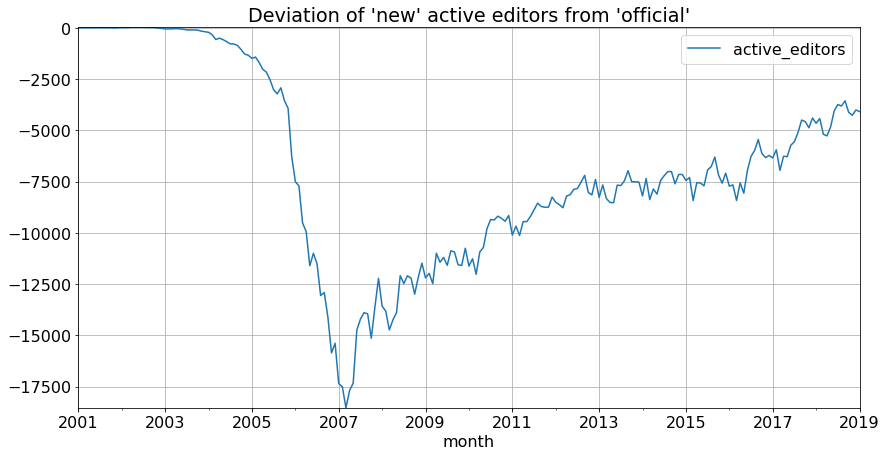

In [422]:
(emn_ae_same_wikis - emo_ae_same_wikis)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

# Unmatched rows

If we use the same selection of wikis, `editor_month_new` has about 476,000 more rows than `editor_month_official`.

In [424]:
row_count_sql = """
select count(*)
from neilpquinn.{table}
where wiki not in {excluded_wikis!r}
"""

emo_row_count_sql = row_count_sql.format(
    table="editor_month_official",
    excluded_wikis=tuple(extra_emo_wikis)
)

emn_row_count_sql = row_count_sql.format(
    table="editor_month_new",
    excluded_wikis=tuple(extra_emn_wikis)
)

In [439]:
hive.run(emn_row_count_sql)

,_c0
0,58998729


In [426]:
hive.run(emo_row_count_sql)

,_c0
0,58522865


Let's find the rows that don't match up.

In [ ]:
unmatched_rows_sql = """
select *
from neilpquinn.editor_month_official emo
full outer join neilpquinn.editor_month_new emn
on
    emo.month = emn.month and
    emo.wiki = emn.wiki and
    emo.local_user_id = emn.local_user_id
where
    coalesce(emo.wiki not in {extra_emo_wikis!r}, true) and
    coalesce(emn.wiki not in {extra_emn_wikis!r}, true) and
    (emo.local_user_id is null or emn.local_user_id is null) 
""".format(
    extra_emo_wikis=tuple(extra_emo_wikis),
    extra_emn_wikis=tuple(extra_emn_wikis)
)

unmatched_rows = hive.run([
    "set hive.resultset.use.unique.column.names=true",
    unmatched_rows_sql
]).rename(columns=lambda x: x.replace(".", "_"))

This gives us about 522,000 unmatched rows, which is about 46,000 more than the overall row count discrepancy. That suggests that we're mostly talking about rows that don't appear at all in one dataset, not about rows that appear in both dataset but didn't match up.

Out of these these unmatched rows, 96% are found only in `editor_month_new` and 4% only in `editor_month_official`.

In [483]:
len(unmatched_rows)

521998

In [484]:
emn_only = unmatched_rows.query("~emn_wiki.isnull()")
len(emn_only)

498931

In [485]:
emo_only = unmatched_rows.query("~emo_wiki.isnull()")
len(emo_only)

23067

The rows found only in `editor_month_new` correspond to revisions [imported](https://www.mediawiki.org/wiki/Manual:Importing_XML_dumps) from one wiki to another. 

The number dropped substantially in the past few years, when `editor_month_official` was being periodically built a month after the fact (unlike the `mediawiki_history`, which is rebuilt completely every month). This suggests that these rows are at least partly a case of "history" being changed gradually after the fact.

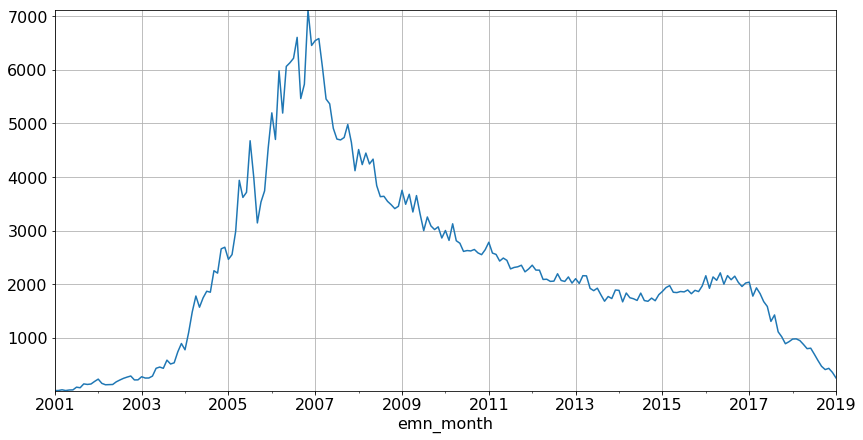

In [486]:
emn_only.groupby("emn_month")["emn_wiki"].count().plot();

The wikis concerned reinforces the idea that these are imported revision. I know dewiki has a policy of importing pages from other wikis before translating them, and it looks like [enwikibooks](https://en.wikibooks.org/wiki/Wikibooks:Requests_for_import) and [simplewiki](https://simple.wikipedia.org/wiki/Wikipedia:Importers) do as well.

In [488]:
emn_only.groupby("emn_wiki")["emn_wiki"].count().sort_values(ascending=False).head(20)

emn_wiki
dewiki           199388
enwikibooks       19982
simplewiki        15261
mlwiki            14980
enwiktionary      14661
elwiki             9991
enwikiversity      6378
zhwikiversity      6198
knwiki             6010
tewiki             5804
bhwiki             5484
nowiki             5138
hiwiki             4921
incubatorwiki      4683
enwiki             4509
frwikibooks        4493
frwikiversity      3879
commonswiki        3579
dewikivoyage       3553
nlwikibooks        3406
Name: emn_wiki, dtype: int64

Looking at 10 random rows, all ten represent imported revisions.

In [500]:
emn_only.sample(10, random_state=18300941).iloc[:, 8:].reset_index(drop=True)

,emn_wiki,emn_month,emn_local_user_id,emn_user_name,emn_edits,emn_content_edits,emn_bot_flag,emn_user_registration
0,elwiki,2010-09-01,210979.0,None,3.0,3.0,False,NaT
1,dewiki,2004-04-01,2800004.0,None,1.0,0.0,False,NaT
2,dewiki,2009-04-01,2796314.0,None,18.0,2.0,False,NaT
3,zhwikiversity,2018-02-01,645.0,None,1.0,0.0,False,NaT
4,itwikivoyage,2016-09-01,12594.0,Bujo,1.0,0.0,False,2015-09-23 20:46:39
5,mlwikisource,2009-03-01,7748.0,None,1.0,0.0,False,NaT
6,dewiki,2011-10-01,828461.0,Pierre Bona,1.0,0.0,False,2009-09-13 16:58:43
7,dewiki,2007-03-01,2807242.0,None,1.0,0.0,False,NaT
8,elwiki,2007-12-01,16985.0,None,1.0,0.0,False,NaT
9,itwiktionary,2004-09-01,58637.0,None,7.0,3.0,False,NaT


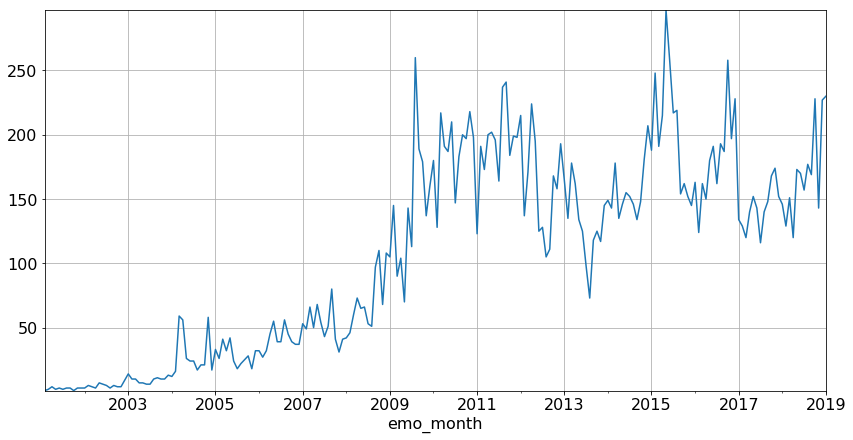

In [526]:
# Filter with a datetime object because there's a "0001-11-30" month which causes all sorts of weirdness
year_2001 = pd.to_datetime("2001")
emo_only.groupby("emo_month")["emo_wiki"].count()[year_2001:].plot();

In [528]:
emo_only.groupby("emo_wiki")["emo_wiki"].count().sort_values(ascending=False).head(20)

emo_wiki
enwiki          9813
jawiki          1470
dewiki           893
ptwiki           564
metawiki         518
ruwiki           462
eswiki           436
zhwiki           417
frwiki           391
trwiki           389
commonswiki      378
plwiki           358
ukwiki           338
cswiki           278
itwiki           246
enwiktionary     246
rowiki           216
hewiki           172
nlwiki           156
simplewiki       145
Name: emo_wiki, dtype: int64

Looking at 10 random rows, all ten represent revisions where the user name was [revision deleted](https://www.mediawiki.org/wiki/Manual:RevisionDelete).

In [530]:
emo_only.sample(10, random_state=18300941).iloc[:, :8].reset_index(drop=True)

,emo_wiki,emo_month,emo_local_user_id,emo_user_name,emo_edits,emo_content_edits,emo_bot_flag,emo_user_registration
0,enwiki,2013-07-01 00:00:00,19329592.0,Darkstyle007,1.0,0.0,False,2013-07-12 10:51:31
1,eswiki,2017-02-01 00:00:00,4525644.0,Taichi se llama Cleofer Fernandez y nacio el 1...,6.0,2.0,False,2017-02-22 22:58:48
2,simplewiki,2013-06-01 00:00:00,312070.0,Newcallgirl9650167345,1.0,0.0,False,2013-06-05 12:17:05
3,eswikinews,2016-10-01 00:00:00,25945.0,My Password Is 4LV4R0 N0LlM4,3.0,0.0,False,2016-10-13 03:09:55
4,enwiki,2009-06-01 00:00:00,9849727.0,Yobronzino,29.0,0.0,False,2009-06-06 19:05:20
5,enwiki,2016-11-01 00:00:00,29781174.0,Anson Antony ASN,1.0,0.0,False,2016-11-30 07:00:16
6,eswiki,2015-08-01 00:00:00,3845166.0,La re putisimamadrequeteremilpario,1.0,0.0,False,2015-07-10 04:13:57
7,enwiki,2013-09-01 00:00:00,19731070.0,Nekama6,1.0,0.0,False,2013-09-15 19:48:11
8,enwiki,2012-06-01 00:00:00,16906819.0,Deepak $harma,4.0,0.0,False,2012-05-30 04:36:11
9,jawiki,2017-11-01 00:00:00,1276845.0,生計に行き詰まって万引き・大空直美,7.0,6.0,False,2017-11-24 12:14:29


Taken together, these had only a minimal impact on the discrepancy.

In [547]:
ae_matched_sql = """
select
    month,
    count(*) as active_editors
from (
    select
        cast({table_abbrev}.month as date) as month,
        {table_abbrev}.user_name,
        sum({table_abbrev}.content_edits) as content_edits,
        max({table_abbrev}.bot_flag) as bot_flag
    from neilpquinn.{table} {table_abbrev}
    inner join neilpquinn.{other_table} {other_table_abbrev}
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where 
        {table_abbrev}.local_user_id != 0
    group by {table_abbrev}.month, {table_abbrev}.user_name
) global_edits
where
    content_edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_matched_sql = ae_matched_sql.format(
    table="editor_month_official",
    table_abbrev="emo",
    other_table="editor_month_new",
    other_table_abbrev="emn"
)

emn_ae_matched_sql = ae_matched_sql.format(
    table="editor_month_new",
    table_abbrev="emn",
    other_table="editor_month_official",
    other_table_abbrev="emo"
)

emo_ae_matched = hive.run(emo_ae_matched_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")
emn_ae_matched = hive.run(emn_ae_matched_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")

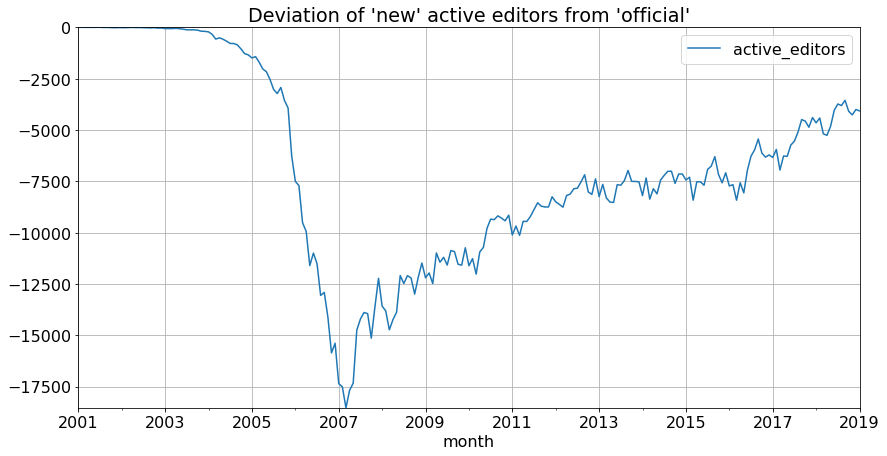

In [548]:
(emn_ae_matched - emo_ae_matched)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

# Content edit counts

So now let's look at the rows that exist in both datasets. Since this is a much bigger group, we'll only look at the past two year of data.

In [36]:
matched_rows = hive.run([
    "set hive.resultset.use.unique.column.names=true",
    """
    select *
    from neilpquinn.editor_month_official emo
    inner join neilpquinn.editor_month_new emn
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where
        emo.month >= "2017-02-01" and
        emn.month >= "2017-02-01"
    """
]).rename(columns=lambda x: x.replace(".", "_"))

12% have different numbers of content edits!

In [588]:
rows = len(matched_rows)
len(matched_rows.query("emo_content_edits != emn_content_edits")) / rows

0.12279135451347824

Of those rows with differing numbers of content edits, `editor_month_official` shows more 96% of the time and `editor_month_new` more only 4% of the time.

In [590]:
differing_content_edit_rows = len(matched_rows.query("emo_content_edits != emn_content_edits"))
len(matched_rows.query("emo_content_edits > emn_content_edits")) / differing_content_edit_rows

0.9634429889371157

Oof. There seem to be at least four different problems at work:

Deleted pages where all the revisions have null `page_namespace_historical`, `page_namespace_is_content` and `page_namespace_is_content_historical`:
* nlwiki page 5160672
* commonswiki page 71797356
* wikidatawiki page 9637937
* arwiki page 4970274
* commonswiki page 73916373
* ruwiki page 7054391

Revisions with null `page_namespace_historical` and `page_namespace_is_content_historical`. Most but not all of the revisions to the pages concerned are affected. 
* https://en.wikipedia.org/w/index.php?diff=67017781 (page 28408157)
* https://www.wikidata.org/w/index.php?diff=155712677 (page 21524228)
* https://pt.wikipedia.org/w/index.php?diff=1691356 (page 96328)
* https://en.wikipedia.org/w/index.php?diff=820879007 (page 56326900)

Revisions where the join to the page table seems to have failed entirely, because where almost all revisions have null `page_title`, `page_namespace`, and `page_namespace_is_content` (including historical fields) and `page_creation_timestamp`. Most but not all of the revisions to the pages concerned are affected.
* https://en.wikipedia.org/w/index.php?diff=859361756 (page 40012938)
* https://pt.wikipedia.org/w/index.php?diff=2692528 (page 3177643)
* https://en.wikipedia.org/w/index.php?diff=269025183 (page 29397754)
* https://en.wikipedia.org/w/index.php?diff=347411263 (page 30865452)

Revisions with null page data (as above) because the referenced pages simply don't exist in the underlying page table. These may be botched deletions.
* https://ru.wikipedia.org/w/index.php?diff=78824747
* https://da.wikipedia.org/w/index.php?diff=1751290
* https://nl.wikipedia.org/w/index.php?diff=1363616
* https://en.wikipedia.org/w/index.php?diff=17967486

In [592]:
matched_rows.query("emo_content_edits > emn_content_edits").sample(10)[
    ["emo_month", "emo_wiki", "emo_local_user_id", "emo_user_name", "emo_content_edits", "emn_content_edits"]
]

,emo_month,emo_wiki,emo_local_user_id,emo_user_name,emo_content_edits,emn_content_edits
5767399,2018-10-01,commonswiki,6241690,Lina Franchina,9,8
1578777,2017-12-01,commonswiki,6947294,Rahul Kumar Chadar,3,2
184541,2017-08-01,ruwiki,1784385,Mr.TiNart,2,0
1141513,2018-08-01,commonswiki,2623039,Franziskanermuseum,2,0
1342731,2017-03-01,enwiki,19048777,Mikejones675,11,10
352790,2018-03-01,commonswiki,4683224,Mcppankaj,2,1
4080152,2017-07-01,wikidatawiki,22740,Black Kite,4,3
326546,2018-02-01,commonswiki,7040082,Penandthinker,1,0
4216076,2018-01-01,commonswiki,36840,Was a bee,34,33
4116231,2017-09-01,enwiki,23616447,LoudLizard,27,14


In the less common case where `editor_month_new` shows more edits, the reasons seem to be:
* content namespaces not included in the list for `editor_month_official`: the Page namespace (104) and Index namespace (106) on enwikisource, the Author namespace (102) and Page namespace (104) on dewikisource, the Page namespace on guwikisource (122), the List namespace of ltwiki (104)
* edits to pages later moved out of content namespaces (e.g. from the main namespace to the user namespace)
* a history merge that moved edits in the Draft namespace to the main namespace (e.g. with the page https://en.wikipedia.org/w/index.php?title=Wyatt_Omsberg&action=history)

In [594]:
matched_rows.query("emn_content_edits > emo_content_edits").sample(10)[
    ["emo_month", "emo_wiki", "emo_local_user_id", "emo_user_name", "emo_content_edits", "emn_content_edits"]
]

,emo_month,emo_wiki,emo_local_user_id,emo_user_name,emo_content_edits,emn_content_edits
5582288,2018-03-01,enwiki,735031,Ged UK,15,17
6894568,2018-03-01,enwiki,32899613,Porcupineforest99,4,6
2712959,2017-05-01,enwikisource,171034,Jane023,25,48
7267799,2017-04-01,sawikisource,0,,3,4
3042151,2018-05-01,ltwiki,78682,Deimantas153,6,8
3812186,2018-10-01,dewikisource,613,Pfaerrich,623,756
7720004,2018-09-01,guwikisource,156,Amvaishnav,0,122
7643298,2018-06-01,knwikisource,4671,Harshithp1810288,0,4
5513594,2017-12-01,hywikisource,6106,Hakob BARSEGHYAN,0,6
1762813,2018-06-01,plwikisource,2417,Ashaio,0,5


This, finally, makes an big impact on the discrepancy: at its largest, it goes from about -19 000 to about -1 200, and in the past year, it goes from about -4 000 to about +50.

In [595]:
ae_all_ns_sql = """
select
    month,
    count(*) as active_editors
from (
    select
        cast({table_abbrev}.month as date) as month,
        {table_abbrev}.user_name,
        sum({table_abbrev}.edits) as edits,
        max({table_abbrev}.bot_flag) as bot_flag
    from neilpquinn.{table} {table_abbrev}
    inner join neilpquinn.{other_table} {other_table_abbrev}
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where 
        {table_abbrev}.local_user_id != 0
    group by {table_abbrev}.month, {table_abbrev}.user_name
) global_edits
where
    edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_all_ns_sql = ae_all_ns_sql.format(
    table="editor_month_official",
    table_abbrev="emo",
    other_table="editor_month_new",
    other_table_abbrev="emn"
)

emn_ae_all_ns_sql = ae_all_ns_sql.format(
    table="editor_month_new",
    table_abbrev="emn",
    other_table="editor_month_official",
    other_table_abbrev="emo"
)

emo_ae_all_ns = hive.run(emo_ae_all_ns_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")
emn_ae_all_ns = hive.run(emn_ae_all_ns_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")

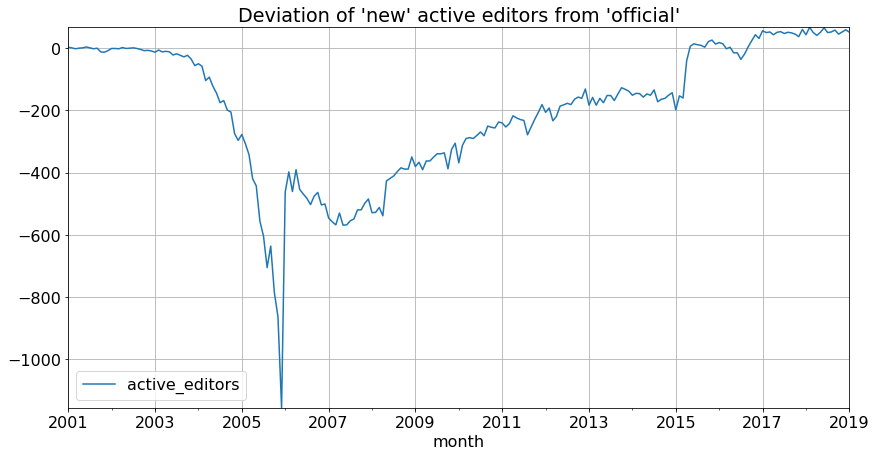

In [596]:
(emn_ae_all_ns - emo_ae_all_ns)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

# Overall edit counts

Only about 0.1% of rows differ in their overall edit count.

In [602]:
differing_edits = matched_rows.query("emo_edits != emn_edits")
len(differing_edits) / rows

0.0011703148602770631

About 63% of these rows show more edits in `editor_month_new`.

In [613]:
len(differing_edits.query("emn_edits > emo_edits")) / len(differing_edits)

0.6343513589240684

The extra edits in `editor_month_new` all seem to be due to imported revisions: for example, where a user was credited with imported revisions *in addition* to making regular revisions during that month, or had some revisions imported before the row in `editor_month_official` was generated, and others imported between that time and now.

In [610]:
differing_edits.query(
    "emn_edits > emo_edits"
).groupby("emo_wiki")["emo_wiki"].count().sort_values(ascending=False).head(20)

emo_wiki
dewiki           3595
commonswiki       591
wikidatawiki      392
simplewiki        306
enwiki            109
mlwiki             88
euwiki             49
metawiki           45
ruwikinews         44
bhwiki             42
dewikivoyage       40
enwikiversity      36
tewiki             35
guwiki             34
knwiki             32
zhwikiversity      32
enwikibooks        31
zhwikivoyage       30
hiwiki             30
maiwiki            30
Name: emo_wiki, dtype: int64

In [618]:
differing_edits.query(
    "(emn_edits > emo_edits) & (emo_wiki == 'commonswiki')"
).sample(10)[
    ["emo_month", "emo_wiki", "emo_local_user_id", "emo_user_name", "emo_edits", "emn_edits"]
]

,emo_month,emo_wiki,emo_local_user_id,emo_user_name,emo_edits,emn_edits
5991535,2017-06-01,commonswiki,2147799,Jc86035,204,205
8765335,2017-12-01,commonswiki,303675,ScAvenger,62,64
7131284,2018-12-01,commonswiki,194176,Jack1956,4,9
7841818,2017-02-01,commonswiki,0,,25194,25265
4517943,2018-12-01,commonswiki,2567522,淺藍雪,26,27
3703070,2018-06-01,commonswiki,238375,Whpq,50,53
7021763,2018-08-01,commonswiki,6701990,AmericanAir88,34,36
7484792,2018-01-01,commonswiki,1047183,FrescoBot,48140,48141
3296041,2017-03-01,commonswiki,4832121,В. Николов,8,9
8685194,2017-09-01,commonswiki,6231175,JJMC89 bot,11448,11451


The extra edits in `editor_month_official` all seem to be due to revision deletion.

In [619]:
differing_edits.query(
    "emo_edits > emn_edits"
).groupby("emo_wiki")["emo_wiki"].count().sort_values(ascending=False).head(20)

emo_wiki
enwiki          1386
jawiki           193
commonswiki      156
enwikivoyage     141
enwiktionary     123
ruwiki           106
fawiki            95
zhwiki            94
plwiki            83
svwiki            76
idwiki            67
ukwiki            64
wikidatawiki      59
eswiki            57
itwiki            56
ptwiki            52
arwiki            52
metawiki          50
frwiki            47
simplewiki        44
Name: emo_wiki, dtype: int64

In [621]:
differing_edits.query(
    "(emo_edits > emn_edits) & (emo_local_user_id != 0)"
).sample(10)[
    ["emo_month", "emo_wiki", "emo_local_user_id", "emo_user_name", "emo_edits", "emn_edits"]
]

,emo_month,emo_wiki,emo_local_user_id,emo_user_name,emo_edits,emn_edits
2807810,2017-09-01,enwiki,5724179,Legacypac,11003,11002
6245378,2018-03-01,enwiktionary,3363551,उक़ाब,2,1
4223344,2018-01-01,enwiki,19835299,Flickerd,3211,3210
5894693,2017-02-01,eswiki,4506595,Ingrid Gomez perra,11,4
6003174,2017-06-01,enwiki,31329968,Christine Kremer,3,2
2594051,2019-01-01,enwiki,31048090,Aryan351,12,11
8787577,2017-12-01,simplewiki,669017,Subhash kumarmb,2,1
6644142,2017-06-01,bgwiki,215747,Димчо Дебелянов,41,29
7554694,2018-03-01,enwiktionary,3340005,WAND124432,8,5
3032527,2018-05-01,enwiki,33694841,VinnyGormund,7,6


This doesn't make a significant impact on the discrepancy; overall, while revision importing and deletion add an unfortunate instability to our metrics, the impact is not big enough for serious concern.

In [ ]:
ae_equal_edits_sql = """
select
    month,
    count(*) as active_editors
from (
    select
        cast({table_abbrev}.month as date) as month,
        {table_abbrev}.user_name,
        greatest(sum({table_abbrev}.edits), sum({other_table_abbrev}.edits)) as edits,
        max({table_abbrev}.bot_flag) as bot_flag
    from neilpquinn.{table} {table_abbrev}
    inner join neilpquinn.{other_table} {other_table_abbrev}
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where 
        {table_abbrev}.local_user_id != 0
    group by {table_abbrev}.month, {table_abbrev}.user_name
) global_edits
where
    edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_equal_edits_sql = ae_equal_edits_sql.format(
    table="editor_month_official",
    table_abbrev="emo",
    other_table="editor_month_new",
    other_table_abbrev="emn"
)

emn_ae_equal_edits_sql = ae_equal_edits_sql.format(
    table="editor_month_new",
    table_abbrev="emn",
    other_table="editor_month_official",
    other_table_abbrev="emo"
)

emo_ae_equal_edits = hive.run(emo_ae_equal_edits_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")
emn_ae_equal_edits = hive.run(emn_ae_equal_edits_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")

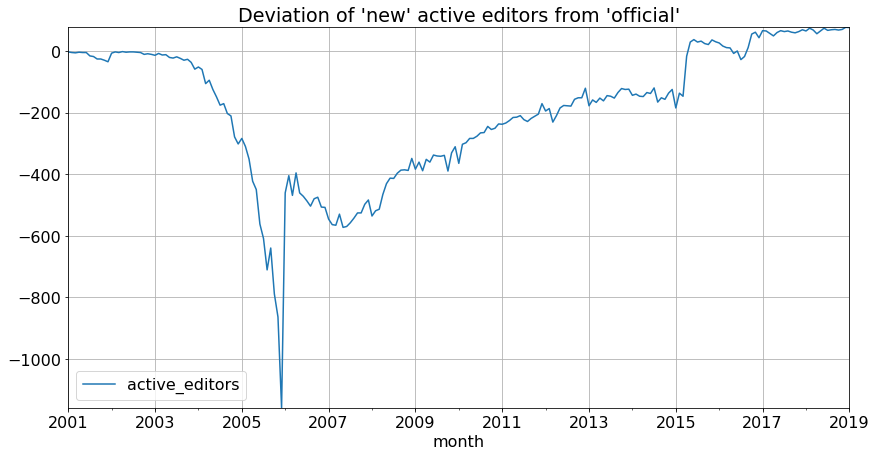

In [623]:
(emn_ae_equal_edits - emo_ae_equal_edits)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

# User names

Let's look at differing user names, filtering out the rows representing anonymous editors because `editor_month_official` gives the user name as an empty string, where `editor_month_new` gives it as null.

In [642]:
differing_names = matched_rows.query("emn_user_name != emo_user_name & emo_local_user_id !=0")

pct_str(len(differing_names) / len(matched_rows))

'0.7%'

These are all cases where the user was renamed after the `editor_month_official` row was generated.

In [643]:
differing_names.sample(10)[
    ["emo_wiki", "emo_month", "emo_user_name", "emn_user_name"]
]

,emo_wiki,emo_month,emo_user_name,emn_user_name
1082445,kowiki,2018-05-01,자성,GustavHerbert
3350162,zhwiki,2017-04-01,萌得不能再萌,CopperSulfate
2053455,enwiki,2017-05-01,Elshadk,ElshadK
1383106,itwiki,2017-04-01,Ikcir,Blueberry72
2775609,zhwiki,2017-07-01,胡蘿蔔,胡葡萄
3345446,pawiktionary,2017-04-01,Stalinjeet,Stalinjeet Brar
6608054,itwiki,2017-04-01,Lioce94,FranZ94
7379680,dawiki,2017-09-01,ChristianGiersing,Christian Giersing
7082519,enwiki,2018-10-01,Wq639,WQ-63
7637346,enwikiquote,2018-06-01,TmY e12,ToprakM


Rerunning the active editor numbers, grouping in both cases by the user name in `editor_month_new`, it has a significant effect on the discrepancy (although not as significant as the content edits issues).

In [645]:
ae_new_names_sql = """
select
    month,
    count(*) as active_editors
from (
    select
        cast({table_abbrev}.month as date) as month,
        emn.user_name,
        greatest(sum({table_abbrev}.edits), sum({other_table_abbrev}.edits)) as edits,
        max({table_abbrev}.bot_flag) as bot_flag
    from neilpquinn.{table} {table_abbrev}
    inner join neilpquinn.{other_table} {other_table_abbrev}
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where 
        {table_abbrev}.local_user_id != 0
    group by {table_abbrev}.month, emn.user_name
) global_edits
where
    edits >= 5 and
    not bot_flag and 
    user_name not regexp "bot\\b"
group by month
"""

emo_ae_new_names_sql = ae_new_names_sql.format(
    table="editor_month_official",
    table_abbrev="emo",
    other_table="editor_month_new",
    other_table_abbrev="emn"
)

emn_ae_new_names_sql = ae_new_names_sql.format(
    table="editor_month_new",
    table_abbrev="emn",
    other_table="editor_month_official",
    other_table_abbrev="emo"
)

emo_ae_new_names = hive.run(emo_ae_new_names_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")
emn_ae_new_names = hive.run(emn_ae_new_names_sql).assign(month=lambda df: pd.to_datetime(df["month"])).set_index("month")

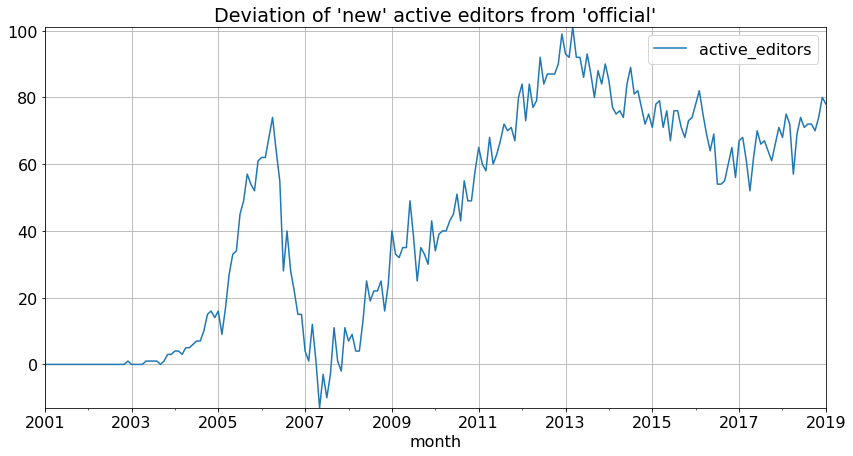

In [646]:
(emn_ae_new_names - emo_ae_new_names)["2001":].plot(
    title="Deviation of 'new' active editors from 'official'"
);

Only the `editor_month_official` active editors number would have changed, since we were already grouping `editor_month_new` by its own `user_name` column. But it looks like very little of that change happened in the past two years (the range covered by the above `differing_names` dataset.

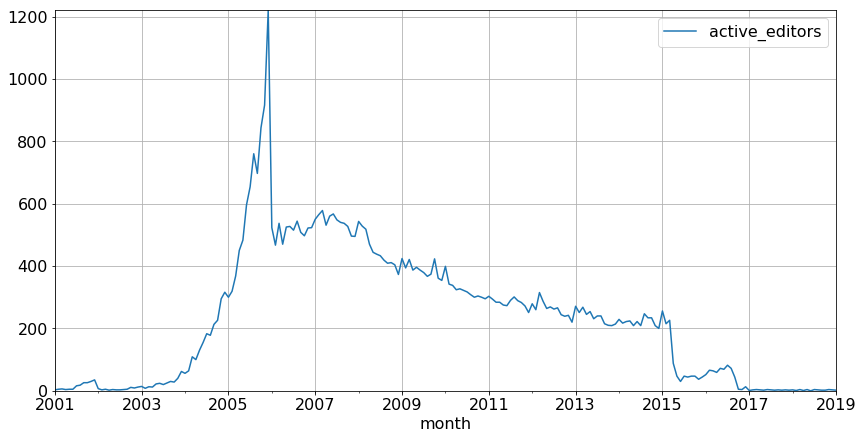

In [661]:
(emo_ae_equal_edits - emo_ae_new_names)["2001":].plot()

So let's get an older sample of differing-name rows and see what's going on.

In [675]:
older_matched_rows = hive.run([
    "set hive.resultset.use.unique.column.names=true",
    """
    select *
    from neilpquinn.editor_month_official emo
    inner join neilpquinn.editor_month_new emn
    on
        emo.month = emn.month and
        emo.wiki = emn.wiki and
        emo.local_user_id = emn.local_user_id
    where
        emo.month >= "2005-01-01" and
        emo.month < "2007-01-01"
    """
]).rename(columns=lambda x: x.replace(".", "_"))

It looks like all of these are cases where `editor_month_new` has a null username, almost certainly cases of [T218463](https://phabricator.wikimedia.org/T218463). 

In [688]:
older_matched_rows.query("emo_user_name != emn_user_name")[
    ["emo_wiki", "emo_month", "emo_user_name", "emn_user_name"]
].sample(20)

,emo_wiki,emo_month,emo_user_name,emn_user_name
1113468,enwiki,2005-08-01,Fortmac,None
3075910,enwikibooks,2006-03-01,Quamaretto~enwikibooks,None
1909442,ptwikibooks,2005-04-01,Lina bia~ptwikibooks,None
28928,dewiki,2005-08-01,Emme.pi.effe,None
1930370,zhwiki,2005-08-01,Adrianus innocens,None
2482232,enwiki,2005-10-01,Dstrange,None
1196632,incubatorwiki,2006-04-01,Rory096,None
2540197,dewiki,2006-04-01,Schiste,None
370409,simplewiki,2006-03-01,BorgHunter,None
1684400,enwiki,2005-12-01,TecoAndJix,None


# Bot flag

In [41]:
differing_bot_flags = matched_rows.query("emo_bot_flag != emn_bot_flag")
len(differing_bot_flags) / len(matched_rows)

0.00031501330226193103

* Grondin: briefly made themself a bot for a test in 2015
* Gala
* CommonsDelinker: made a local bot at tewiki on 2018-12-22

* Does `mediawiki_history` look at the global bot group?

In [35]:
hive.run("""
select
    event_user_groups,
    event_user_groups_historical
from wmf.mediawiki_history
where
    wiki_db = "frwikinews" and
    event_user_text = "Grondin" and
    date_format(event_timestamp, "yyyy-MM") = "2017-07" and
    event_entity = "revision" and
    snapshot = "2019-03"
limit 1
""")

,event_user_groups,event_user_groups_historical
0,"[""accountcreator"",""bureaucrat"",""facilitator"",""...","[""sysop"",""trusteduser"",""facilitator"",""bureaucr..."


In [44]:
_35.iloc[0, 0]

'["accountcreator","bureaucrat","facilitator","interface-admin","ipblock-exempt","sysop","trusteduser"]'

In [691]:
bot_flag_columns = [
    "emo_wiki",
    "emo_month",
    "emo_user_name",
    "emo_bot_flag",
    "emn_user_name",
    "emn_bot_flag"
]

.sample(20)[bot_flag_columns]

,emo_wiki,emo_month,emo_user_name,emo_bot_flag,emn_user_name,emn_bot_flag
3699467,tewiki,2018-05-01,CommonsDelinker,False,CommonsDelinker,True
154172,frwikinews,2017-07-01,Grondin,True,Grondin,False
3171027,eswikivoyage,2018-10-01,Galahad,True,Galahad,False
8666077,enwiki,2017-08-01,William Avery Bot,False,William Avery Bot,True
7449846,itwikisource,2017-11-01,Alex brollo,True,Alex brollo,False
5162349,kkwiki,2018-11-01,Нұрлан Рахымжанов,True,Нұрлан Рахымжанов,False
2796282,nlwiki,2017-08-01,Wiki13,True,Wiki13,False
4750702,eswiktionary,2017-08-01,BotSinNombre,True,BotSinNombre,False
5490526,ptwiki,2017-11-01,RadiX,True,RadiX,False
3777386,tewiki,2018-08-01,ChaduvariAWBNew,False,ChaduvariAWBNew,True


In [573]:
len(matched_rows.query("emo_user_registration != emn_user_registration")) / rows

0.025009345467502914